# Final Project: The Rumos Bank 

The Rumos Bank has been losing a lot of money due to the number of loans it provides that are not paid back on time. 

    - For every customer who is expected not to pay on time and does pay, the bank has a cost of 1000 euros. 

    - For every customer who is expected to pay on time and fails, the bank has a cost of 3000 euros.


Since you are a top data scientist, you were hired to help the bank predict which clients will fail to pay on time, so that it can better manage its funds.

Can you build a model that can successfully detect bad paying clients in advance?


Dataset: https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

Available features:

    ID: ID of each client
    LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
    SEX: Gender (1=male, 2=female)
    EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
    MARRIAGE: Marital status (1=married, 2=single, 3=others)
    AGE: Age in years
    PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
    PAY_2: Repayment status in August, 2005 (scale same as above)
    PAY_3: Repayment status in July, 2005 (scale same as above)
    PAY_4: Repayment status in June, 2005 (scale same as above)
    PAY_5: Repayment status in May, 2005 (scale same as above)
    PAY_6: Repayment status in April, 2005 (scale same as above)
    BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
    BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
    BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
    BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
    BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
    BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
    PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
    PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
    PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
    PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
    PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
    PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
    default.payment.next.month: Default payment (1=yes, 0=no)

#### Questions:

    1. How many features are available? How many clients?
    2. How many clients do you have in your dataset who have actually been bad payers? And how many were not?
    3. Which model led to the best results? What metrics were used to compare the different models?
    4. What are the most relevant features to predict whether a client is more likely to be a bad payer?
    5. What would be the cost that the bank would have without any model?
    6. What is the cost to the bank with your model?

Assumptions:

    True positive - Bad payers are identified correctly.
    True negative - Good payers are correctly identified.
    False positive - A good payer is identified as a bad payer.
    False negative - A bad payer is identified as a good payer.

In [137]:
root_path = '../data/'

In [138]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

SEED = 42

In [139]:
#read data into dataframe
df = pd.read_csv(root_path + 'lending_data.csv')

In [140]:
#dataframe shape
df.shape

(30000, 25)

In [141]:
#show dataframe 
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [142]:
#number of unique id
df.ID.nunique()

30000

#### 1. How many features are available? How many clients?

    - There are 24 features available on the dataset.
    - There are 30000 clients.

Are there any missing values?

In [143]:
#check for missing values
df.isnull().values.any()

np.False_

No missing values where found.

Do all classes have the same number of clients?

In [144]:
#number of clients in each class
df.groupby('default.payment.next.month')['default.payment.next.month'].count()

default.payment.next.month
0    23364
1     6636
Name: default.payment.next.month, dtype: int64

No! The dataset is highly unbalanced.

#### 2. How many clients do you have in your dataset who have actually been bad payers? And how many were not?

    - 23,364 were good payers. 6,636 were bad payers.

Check the data type of each features, is there any categorical feature?

In [145]:
#check the data type in each features
df.dtypes

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

All features are numeric.

Next we need to drop the ID column.

In [146]:
#remove id from dataset
df = df.drop('ID', axis = 1)


Split the dataset into training and testing

In [147]:
#split the dataframe into training and testing
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = SEED)

In [148]:
#target column
TARGET_COL = 'default.payment.next.month'

In [149]:
X_train = train_set.drop([TARGET_COL], axis = 'columns') #get the features for the training dataframe
y_train = train_set[TARGET_COL] #get the target for the training dataframe

X_test = test_set.drop([TARGET_COL], axis = 1) #get the features for the testing dataframe
y_test = test_set[TARGET_COL] #get the target for the testing dataframe

In [150]:
#Save the training and testing data in the data folder
X_train.to_csv(f'{root_path}train_features.csv', index=False)
y_train.to_csv(f'{root_path}train_labels.csv', index=False)
X_test.to_csv(f'{root_path}test_features.csv', index=False)
y_test.to_csv(f'{root_path}test_labels.csv', index=False)

Normalization:

In [151]:
scaler = MinMaxScaler() 

features_names = X_train.columns #get a list with the name of the features

X_train_scaled = scaler.fit_transform(X_train) #scales the training features 
X_train_scaled = pd.DataFrame(X_train_scaled, columns = features_names) #creates a dataframe with the scaled features

X_test_scaled = scaler.transform(X_test) #scales the testing features
X_test_scaled = pd.DataFrame(X_test_scaled, columns = features_names) #creates a dataframe with the scaled features

Before we start, let's calculate the model baseline, which means the cost the bank has without any model.

$$totalCost = 1000∗FP+3000∗FN$$

Baseline assuming that all clients are bad payers

In [152]:
y_preds_all_bad = np.ones(y_test.shape) #creates an array with only 1 with the size of y_test

tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_bad).ravel() #gets the confusion matrix 

print(f'Number of True Negatives: {tn}') 
print(f'Number of True Positives: {tp}')
print(f'Number of False Negatives: {fn}')
print(f'Number of False Positives: {fp}')
print('\n')

accuracy = accuracy_score(y_test, y_preds_all_bad) #calculate the accuracy
recall = recall_score(y_test, y_preds_all_bad) #calculate the recall
total_cost = fp * 1000 #calculate the total cost

print(f'Total Cost: {total_cost}')
print(f'accuracy: {accuracy}')
print(f'recall: {recall}')


Number of True Negatives: 0
Number of True Positives: 1313
Number of False Negatives: 0
Number of False Positives: 4687


Total Cost: 4687000
accuracy: 0.21883333333333332
recall: 1.0


If all clients are considered bad payers the bank has a total cost of 4,687,000 Euros.

Baseline assuming all clients are good payers

In [153]:
y_preds_all_good = np.zeros(y_test.shape) #creates an array with only 1 with the size of y_test

tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_good).ravel() #gets the confusion matrix 

print(f'Number of True Negatives: {tn}') 
print(f'Number of True Positives: {tp}')
print(f'Number of False Negatives: {fn}')
print(f'Number of False Positives: {fp}')
print('\n')

accuracy = accuracy_score(y_test, y_preds_all_good) #calculate the accuracy
recall = recall_score(y_test, y_preds_all_good) #calculate the recall
total_cost = fn * 3000 #calculate the total cost

print(f'Total Cost: {total_cost}')
print(f'accuracy: {accuracy}')
print(f'recall: {recall}')

Number of True Negatives: 4687
Number of True Positives: 0
Number of False Negatives: 1313
Number of False Positives: 0


Total Cost: 3939000
accuracy: 0.7811666666666667
recall: 0.0


If all clients are considered good payers the bank has a total cost of 3,939,000 Euros.

In [154]:
#functions that calculates the total cost considering the threshold
def total_cost(y_test, y_preds, threshold = 0.5):
    
    tn, fp, fn, tp = confusion_matrix(y_test == 1, y_preds > threshold).ravel()
    
    cost_fn = fn*3000
    cost_fp = fp*1000

    total_cost = cost_fn + cost_fp
    
    return total_cost
    

In [155]:
#function that calculates and plots the total cost for diferent thresholds 
def min_cost_threshold(y_test, y_preds):
    
    costs = {}
    
    for threshold in np.arange(0, 1.1, 0.1):
        
        costs[round(threshold, 1)] = total_cost(y_test, y_preds, threshold = threshold)
        
    plt.plot(list(costs.keys()), list(costs.values()))
    plt.title('Total Cost by Threshold')
    plt.ylabel('Total Costa')
    plt.xlabel('Threshold')
    plt.show()
    

#### Logistic Regression

In [156]:
%%time
lr = LogisticRegression(max_iter = 500, solver = 'lbfgs', random_state = SEED, class_weight = 'balanced' ) #creates a logistic regression model

parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100]} #define the parameters to be tested

clf_lr = GridSearchCV(lr, parameters, cv = 5).fit(X_train_scaled, y_train) #performs a grid search to test each parameter

CPU times: total: 2.88 s
Wall time: 2.88 s


In [157]:
y_preds = clf_lr.predict_proba(X_test_scaled)[:,1] #client´s probability of being allocated on class 1

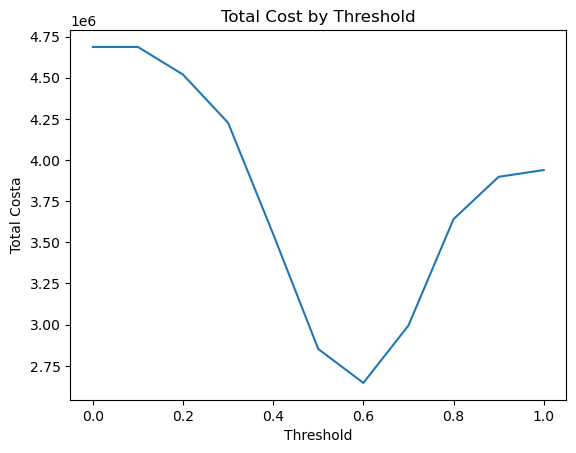

In [158]:
min_cost_threshold(y_test, y_preds)

For logistic regression the threshold that minimizes the total cost is 0.6.

In [159]:
min_cost = total_cost(y_test, y_preds, threshold = 0.6) #calculate the total cost for threshold=0.6
print(f'Total cost for threshold=0.6: {min_cost}')

Total cost for threshold=0.6: 2646000


In [160]:
clf_lr.best_params_

{'C': 0.1}

The total cost for a threshold of 0.6 is 2,646,000 Euros, which is better than the baseline!

Now let's create a run to log the parameters and associated metrics and register the logistic regression model. 

#### Logistic Regression RUN

In [161]:
uri = "http://localhost:5000"

mlflow.set_tracking_uri(uri)

mlflow.set_experiment("Rumos Banking Leading Prediciton")

2025/03/17 23:19:27 INFO mlflow.tracking.fluent: Experiment with name 'Rumos Banking Leading Prediciton' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/136655034151278466', creation_time=1742253567334, experiment_id='136655034151278466', last_update_time=1742253567334, lifecycle_stage='active', name='Rumos Banking Leading Prediciton', tags={}>

In [162]:
with mlflow.start_run(run_name="Logistic Regression - best parameters - pipeline"):

    train_dataset = mlflow.data.from_pandas(train_set, targets=TARGET_COL, name="Bank Train Dataset")
    test_dataset = mlflow.data.from_pandas(test_set, targets=TARGET_COL, name="Bank Test Dataset")
    mlflow.log_input(train_dataset, context="train")
    mlflow.log_input(test_dataset, context="test")
    
    #log the training and testing data
    mlflow.log_artifact(f'{root_path}train_features.csv')
    mlflow.log_artifact(f'{root_path}train_labels.csv')
    mlflow.log_artifact(f'{root_path}test_features.csv')
    mlflow.log_artifact(f'{root_path}test_labels.csv')
    
    mlflow.log_param("seed", SEED) #log the seed

    #create the pipeline for the best parameters
    lr_pipeline = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("model", clf_lr.best_estimator_)
    ])

    lr_pipeline.fit(X_train, y_train) #fit the pipeline with the training data
    mlflow.sklearn.log_model(lr_pipeline, artifact_path="lr_pipeline", registered_model_name="logistic_reg") #log the pipeline

    params=lr_pipeline.get_params()

    #change the parameters name
    modified_params = {}
    for k, v in params.items():
        new_key = k.replace("model__", '')
        modified_params[new_key] = v

    mlflow.log_params(modified_params) #log the parameters

    y_preds = lr_pipeline.predict_proba(X_test)[:,1]
    y_preds_threshold = (lr_pipeline.predict_proba(X_test)[:,1] > 0.6).astype(int) #predictions for threshold=0.6

    acc = accuracy_score(y_test, y_preds_threshold) #calculate accuracy for threshold=0.6
    rec = recall_score(y_test, y_preds_threshold) #calculate recall for threshold=0.6
    roc = roc_auc_score(y_test, y_preds_threshold) #calculate roc curve for threshold=0.6

    min_cost = total_cost(y_test, y_preds, threshold = 0.6) #calculate total cost for threshold=0.6
    
    #log metrics
    mlflow.log_metric("accuracy", acc) 
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("roc_auc", roc)
    mlflow.log_metric("min_cost", min_cost)

c:\Users\jmigu\anaconda3\envs\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/03/17 23:19:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'logistic

🏃 View run Logistic Regression - best parameters - pipeline at: http://localhost:5000/#/experiments/136655034151278466/runs/d5787dc74b904d0d89dfb69c4d259611
🧪 View experiment at: http://localhost:5000/#/experiments/136655034151278466


#### KNN

In [163]:
%%time
knn = KNeighborsClassifier() #creates a KNeighborsClassifier model

parameters = {'n_neighbors': range(1,10, 1)} #define the parameters to be tested

clf_knn = GridSearchCV(knn, parameters, cv = 5).fit(X_train_scaled, y_train) #performs a grid search to test each parameter

CPU times: total: 1min 14s
Wall time: 20.6 s


KNN is not a suitable method for large datasets! Let's see if it is worth in terms of results:

In [164]:
y_preds = clf_knn.predict_proba(X_test_scaled)[:,1] #client´s probability of being allocated on class 1

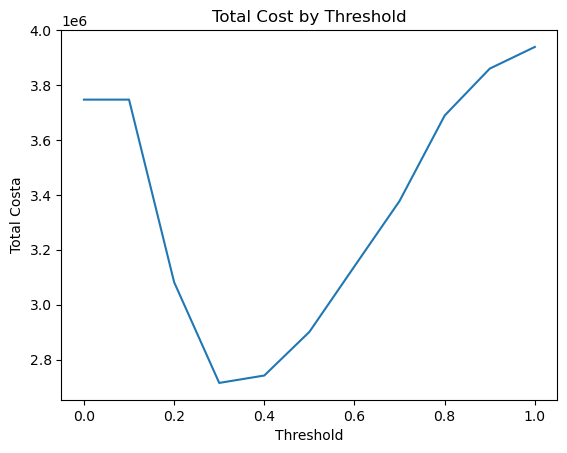

In [165]:
min_cost_threshold(y_test, y_preds)

In [166]:
min_cost = total_cost(y_test, y_preds, threshold = 0.3) #calculate the total cost for threshold=0.3
print(f'Total cost for threshold=0.3: {min_cost}')

Total cost for threshold=0.3: 2715000


In [167]:
clf_knn.best_params_

{'n_neighbors': 9}

Better than the baseline but worst than logistic regression.

Now let's create a run to log the parameters and associated metrics and register the KNeighborsClassifier model.

#### KNeighborsClassifier RUN

In [168]:
with mlflow.start_run(run_name="KNeighborsClassifier - best parameters - pipeline"):

    train_dataset = mlflow.data.from_pandas(train_set, targets=TARGET_COL, name="Bank Train Dataset")
    test_dataset = mlflow.data.from_pandas(test_set, targets=TARGET_COL, name="Bank Test Dataset")
    mlflow.log_input(train_dataset, context="train")
    mlflow.log_input(test_dataset, context="test")
    
    #log the training and testing data
    mlflow.log_artifact(f'{root_path}train_features.csv')
    mlflow.log_artifact(f'{root_path}train_labels.csv')
    mlflow.log_artifact(f'{root_path}test_features.csv')
    mlflow.log_artifact(f'{root_path}test_labels.csv')
    
    mlflow.log_param("seed", SEED) #log the seed

    #create the pipeline for the best parameters
    knn_pipeline = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("model", clf_knn.best_estimator_)
    ])

    knn_pipeline.fit(X_train, y_train) #fit the pipeline with the training data
    mlflow.sklearn.log_model(knn_pipeline, artifact_path="knn_pipeline", registered_model_name="KNeighborsClassifier") #log the pipeline

    params=knn_pipeline.get_params()

    #change the parameters name
    modified_params = {}
    for k, v in params.items():
        new_key = k.replace("model__", '')
        modified_params[new_key] = v

    mlflow.log_params(modified_params) #log the parameters

    y_preds = knn_pipeline.predict_proba(X_test)[:,1]
    y_preds_threshold = (knn_pipeline.predict_proba(X_test)[:,1] > 0.3).astype(int) #predictions for threshold=0.3

    acc = accuracy_score(y_test, y_preds_threshold) #calculate accuracy for threshold=0.3
    rec = recall_score(y_test, y_preds_threshold) #calculate recall for threshold=0.3
    roc = roc_auc_score(y_test, y_preds_threshold) #calculate roc curve for threshold=0.3

    min_cost = total_cost(y_test, y_preds, threshold = 0.3) #calculate total cost for threshold=0.3
    
    #log metrics
    mlflow.log_metric("accuracy", acc) 
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("roc_auc", roc)
    mlflow.log_metric("min_cost", min_cost)

c:\Users\jmigu\anaconda3\envs\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/03/17 23:20:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'KNeighbo

🏃 View run KNeighborsClassifier - best parameters - pipeline at: http://localhost:5000/#/experiments/136655034151278466/runs/a2cff5ad21994be983d5a4c211715cc5
🧪 View experiment at: http://localhost:5000/#/experiments/136655034151278466


#### SVM

In [169]:
%%time
svc = SVC(random_state = SEED, class_weight = 'balanced', gamma = 'scale', probability = True, verbose = True) #creates a support vector machine model

parameters = {'C':[0.1, 1, 10], 'kernel': ('rbf', 'linear') } #define the parameters to be tested

clf_svc = GridSearchCV(svc, parameters, cv = 5).fit(X_train_scaled, y_train) #perfoms a grid search to test each parameter

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]CPU times: total: 1h 7min 4s
Wall time: 1h 7min 51s


In [170]:
y_preds = clf_svc.predict_proba(X_test_scaled)[:,1] #client´s probability of being allocated on class 1

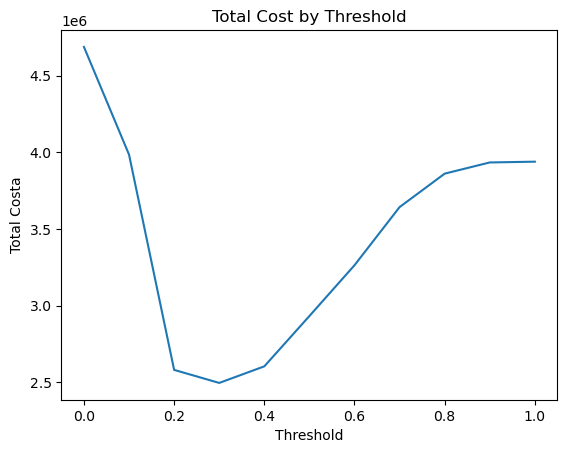

In [171]:
min_cost_threshold(y_test, y_preds)

In [172]:
min_cost = total_cost(y_test, y_preds, threshold = 0.3) #calculate the total cost for threshold=0.3
print(f'Total cost for threshold=0.3: {min_cost}')

Total cost for threshold=0.3: 2497000


In [173]:
clf_svc.best_params_

{'C': 0.1, 'kernel': 'rbf'}

Best model so far!

Now let's create a run to log the parameters and associated metrics and register the support vector machine model.

#### SVC RUN

In [174]:
with mlflow.start_run(run_name="SVC - best parameters - pipeline"):

    train_dataset = mlflow.data.from_pandas(train_set, targets=TARGET_COL, name="Bank Train Dataset")
    test_dataset = mlflow.data.from_pandas(test_set, targets=TARGET_COL, name="Bank Test Dataset")
    mlflow.log_input(train_dataset, context="train")
    mlflow.log_input(test_dataset, context="test")
    
    #log the training and testing data
    mlflow.log_artifact(f'{root_path}train_features.csv')
    mlflow.log_artifact(f'{root_path}train_labels.csv')
    mlflow.log_artifact(f'{root_path}test_features.csv')
    mlflow.log_artifact(f'{root_path}test_labels.csv')
    
    mlflow.log_param("seed", SEED) #log the seed

    #create the pipeline for the best parameters
    svc_pipeline = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("model", clf_svc.best_estimator_)
    ])

    svc_pipeline.fit(X_train, y_train) #fit the pipeline with the training data
    mlflow.sklearn.log_model(svc_pipeline, artifact_path="svc_pipeline", registered_model_name="SVC") #log the pipeline

    params=svc_pipeline.get_params()

    #change the parameters name
    modified_params = {}
    for k, v in params.items():
        new_key = k.replace("model__", '')
        modified_params[new_key] = v

    mlflow.log_params(modified_params) #log the parameters

    y_preds = svc_pipeline.predict_proba(X_test)[:,1]
    y_preds_threshold = (svc_pipeline.predict_proba(X_test)[:,1] > 0.3).astype(int) #predictions for threshold=0.3

    acc = accuracy_score(y_test, y_preds_threshold) #calculate accuracy for threshold=0.3
    rec = recall_score(y_test, y_preds_threshold) #calculate recall for threshold=0.3
    roc = roc_auc_score(y_test, y_preds_threshold) #calculate roc curve for threshold=0.3

    min_cost = total_cost(y_test, y_preds, threshold = 0.3) #calculate total cost for threshold=0.3
    
    #log metrics
    mlflow.log_metric("accuracy", acc) 
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("roc_auc", roc)
    mlflow.log_metric("min_cost", min_cost)

c:\Users\jmigu\anaconda3\envs\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


[LibSVM]

2025/03/18 00:32:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'SVC'.
2025/03/18 00:32:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVC, version 1
Created version '1' of model 'SVC'.


🏃 View run SVC - best parameters - pipeline at: http://localhost:5000/#/experiments/136655034151278466/runs/620dd46871d24edc95bd439f1ce37a10
🧪 View experiment at: http://localhost:5000/#/experiments/136655034151278466


#### Decision Trees

In [175]:
%%time
trees = tree.DecisionTreeClassifier(random_state = SEED,  class_weight = 'balanced') #creates a decision tree model

parameters = {'max_depth':[3, 6], 'min_samples_split': [2, 4, 10]} #define the parameters to be tested

clf_tree = GridSearchCV(trees, parameters, cv = 5).fit(X_train_scaled, y_train) #perform grid search for each parameter

CPU times: total: 4.27 s
Wall time: 4.32 s


In [176]:
y_preds = clf_tree.predict_proba(X_test_scaled)[:,1] #client´s probability of being allocated on class 1

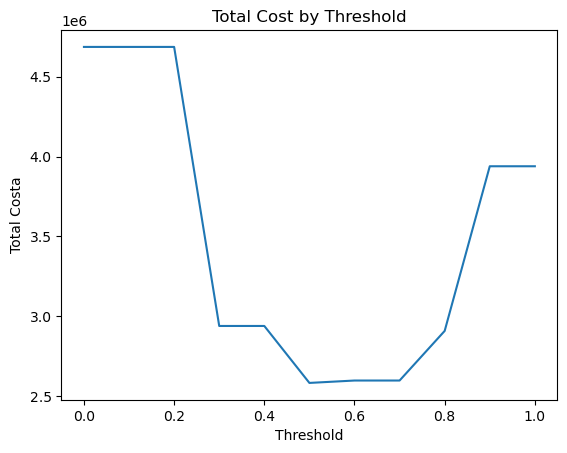

In [177]:
min_cost_threshold(y_test, y_preds)

In [178]:
min_cost = total_cost(y_test, y_preds, threshold = 0.5) #calculate the total cost for threshold=0.5
print(f'Total cost for threshold=0.5: {min_cost}')

Total cost for threshold=0.5: 2581000


In [179]:
clf_tree.best_params_

{'max_depth': 3, 'min_samples_split': 2}

SVMs still the best model.

Now let's create a run to log the parameters and associated metrics and register the decision tree model.

#### Decision Tree RUN

In [180]:
with mlflow.start_run(run_name="Decision Tree - best parameters - pipeline"):

    train_dataset = mlflow.data.from_pandas(train_set, targets=TARGET_COL, name="Bank Train Dataset")
    test_dataset = mlflow.data.from_pandas(test_set, targets=TARGET_COL, name="Bank Test Dataset")
    mlflow.log_input(train_dataset, context="train")
    mlflow.log_input(test_dataset, context="test")
    
    #log the training and testing data
    mlflow.log_artifact(f'{root_path}train_features.csv')
    mlflow.log_artifact(f'{root_path}train_labels.csv')
    mlflow.log_artifact(f'{root_path}test_features.csv')
    mlflow.log_artifact(f'{root_path}test_labels.csv')
    
    mlflow.log_param("seed", SEED) #log the seed

    #create the pipeline for the best parameters
    tree_pipeline = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("model", clf_tree.best_estimator_)
    ])

    tree_pipeline.fit(X_train, y_train) #fit the pipeline with the training data
    mlflow.sklearn.log_model(tree_pipeline, artifact_path="tree_pipeline", registered_model_name="Decision_tree") #log the pipeline

    params=tree_pipeline.get_params()

    #change the parameters name
    modified_params = {}
    for k, v in params.items():
        new_key = k.replace("model__", '')
        modified_params[new_key] = v

    mlflow.log_params(modified_params) #log the parameters

    y_preds = tree_pipeline.predict_proba(X_test)[:,1]
    y_preds_threshold = (tree_pipeline.predict_proba(X_test)[:,1] > 0.5).astype(int) #predictions for threshold=0.5

    acc = accuracy_score(y_test, y_preds_threshold) #calculate accuracy for threshold=0.5
    rec = recall_score(y_test, y_preds_threshold) #calculate recall for threshold=0.5
    roc = roc_auc_score(y_test, y_preds_threshold) #calculate roc curve for threshold=0.5

    min_cost = total_cost(y_test, y_preds, threshold = 0.5) #calculate total cost for threshold=0.5
    
    #log metrics
    mlflow.log_metric("accuracy", acc) 
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("roc_auc", roc)
    mlflow.log_metric("min_cost", min_cost)

c:\Users\jmigu\anaconda3\envs\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/03/18 00:33:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Decision

🏃 View run Decision Tree - best parameters - pipeline at: http://localhost:5000/#/experiments/136655034151278466/runs/e8553a6116e5474ba3eadb02a141efcb
🧪 View experiment at: http://localhost:5000/#/experiments/136655034151278466


#### Random Forests

In [181]:
%%time 
rf = RandomForestClassifier(random_state = SEED,  class_weight = 'balanced') #creates a random forest model

parameters = {'n_estimators':[10, 100]} #define the parameters to be tested

clf_rf = GridSearchCV(rf, parameters, cv = 5).fit(X_train_scaled, y_train) #performs grid search for each parameter

CPU times: total: 39.5 s
Wall time: 39.7 s


In [182]:
y_preds = clf_rf.predict_proba(X_test_scaled)[:,1] #client's probability of being allocated on class 1

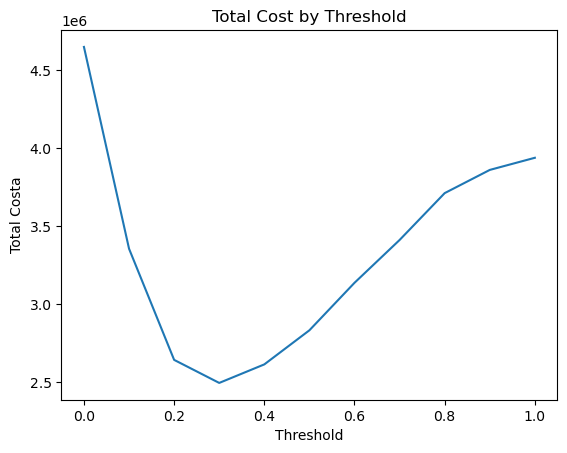

In [183]:
min_cost_threshold(y_test, y_preds)

In [184]:
min_cost = total_cost(y_test, y_preds, threshold = 0.30) #calculate the total cost for threshold=0.3
print(f'Total cost for threshold=0.3: {min_cost}')

Total cost for threshold=0.3: 2493000


In [185]:
clf_rf.best_params_

{'n_estimators': 100}

Best result so far!

Now let's create a run to log the parameters and associated metrics and register the random forest model.

#### Random Forest RUN

In [186]:
with mlflow.start_run(run_name="Random Forest - best parameters - pipeline"):

    train_dataset = mlflow.data.from_pandas(train_set, targets=TARGET_COL, name="Bank Train Dataset")
    test_dataset = mlflow.data.from_pandas(test_set, targets=TARGET_COL, name="Bank Test Dataset")
    mlflow.log_input(train_dataset, context="train")
    mlflow.log_input(test_dataset, context="test")
    
    #log the training and testing data
    mlflow.log_artifact(f'{root_path}train_features.csv')
    mlflow.log_artifact(f'{root_path}train_labels.csv')
    mlflow.log_artifact(f'{root_path}test_features.csv')
    mlflow.log_artifact(f'{root_path}test_labels.csv')
    
    mlflow.log_param("seed", SEED) #log the seed

    #create the pipeline for the best parameters
    rf_pipeline = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("model", clf_rf.best_estimator_)
    ])

    rf_pipeline.fit(X_train, y_train) #fit the pipeline with the training data
    mlflow.sklearn.log_model(rf_pipeline, artifact_path="rf_pipeline", registered_model_name="Random_forest") #log the pipeline

    params=rf_pipeline.get_params()

    #change the parameters name
    modified_params = {}
    for k, v in params.items():
        new_key = k.replace("model__", '')
        modified_params[new_key] = v

    mlflow.log_params(modified_params) #log the parameters

    y_preds = rf_pipeline.predict_proba(X_test)[:,1]
    y_preds_threshold = (rf_pipeline.predict_proba(X_test)[:,1] > 0.3).astype(int) #predictions for threshold=0.3

    acc = accuracy_score(y_test, y_preds_threshold) #calculate accuracy for threshold=0.3
    rec = recall_score(y_test, y_preds_threshold) #calculate recall for threshold=0.3
    roc = roc_auc_score(y_test, y_preds_threshold) #calculate roc curve for threshold=0.3

    min_cost = total_cost(y_test, y_preds, threshold = 0.3) #calculate total cost for threshold=0.3
    
    #log metrics
    mlflow.log_metric("accuracy", acc) 
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("roc_auc", roc)
    mlflow.log_metric("min_cost", min_cost)

c:\Users\jmigu\anaconda3\envs\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/03/18 00:33:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Random_f

🏃 View run Random Forest - best parameters - pipeline at: http://localhost:5000/#/experiments/136655034151278466/runs/256f55fddafe4813bc70fdaf712c6bfa
🧪 View experiment at: http://localhost:5000/#/experiments/136655034151278466


#### Neural Networks

In [187]:
%%time
mlp = MLPClassifier(solver = 'lbfgs',  random_state = SEED, max_iter = 1000) #creates a neural network model

parameters = {'hidden_layer_sizes': [(20,), (20,10), (20, 10, 2)], 'learning_rate_init':[0.0001, 0.001, 0.01, 0.1]} #define the parameters to be tested

clf_mlp = GridSearchCV(mlp, parameters, cv = 5).fit(X_train_scaled, y_train) #perform grid search for each parameter

c:\Users\jmigu\anaconda3\envs\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\jmigu\anaconda3\envs\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\jmigu\anaconda3\envs\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (sta

CPU times: total: 1h 32min 34s
Wall time: 15min 59s


c:\Users\jmigu\anaconda3\envs\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [188]:
y_preds = clf_mlp.predict_proba(X_test_scaled)[:,1] #client's probability of being allocated on class 1

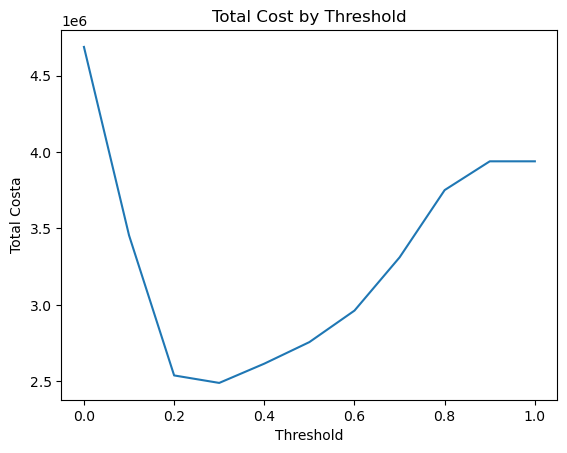

In [189]:
min_cost_threshold(y_test, y_preds)

In [190]:
min_cost = total_cost(y_test, y_preds, threshold = 0.3) #calculate the total cost for threshold=0.3
print(f'Total cost for threshold=0.3: {min_cost}')

Total cost for threshold=0.3: 2490000


Slightly better than Random Forest but took more time to compute!

Now let's create a run to log the parameters and associated metrics and register the neural networks model.

#### Neural Networks RUN

In [191]:
with mlflow.start_run(run_name="Neural Networks - best parameters - pipeline"):

    train_dataset = mlflow.data.from_pandas(train_set, targets=TARGET_COL, name="Bank Train Dataset")
    test_dataset = mlflow.data.from_pandas(test_set, targets=TARGET_COL, name="Bank Test Dataset")
    mlflow.log_input(train_dataset, context="train")
    mlflow.log_input(test_dataset, context="test")
    
    #log the training and testing data
    mlflow.log_artifact(f'{root_path}train_features.csv')
    mlflow.log_artifact(f'{root_path}train_labels.csv')
    mlflow.log_artifact(f'{root_path}test_features.csv')
    mlflow.log_artifact(f'{root_path}test_labels.csv')
    
    mlflow.log_param("seed", SEED) #log the seed

    #create the pipeline for the best parameters
    ann_pipeline = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("model", clf_mlp.best_estimator_)
    ])

    ann_pipeline.fit(X_train, y_train) #fit the pipeline with the training data
    mlflow.sklearn.log_model(ann_pipeline, artifact_path="ann_pipeline", registered_model_name="Neural_networks") #log the pipeline

    params=ann_pipeline.get_params()

    #change the parameters name
    modified_params = {}
    for k, v in params.items():
        new_key = k.replace("model__", '')
        modified_params[new_key] = v

    mlflow.log_params(modified_params) #log the parameters

    y_preds = ann_pipeline.predict_proba(X_test)[:,1]
    y_preds_threshold = (ann_pipeline.predict_proba(X_test)[:,1] > 0.3).astype(int) #predictions for threshold=0.3

    acc = accuracy_score(y_test, y_preds_threshold) #calculate accuracy for threshold=0.3
    rec = recall_score(y_test, y_preds_threshold) #calculate recall for threshold=0.3
    roc = roc_auc_score(y_test, y_preds_threshold) #calculate roc curve for threshold=0.3

    min_cost = total_cost(y_test, y_preds, threshold = 0.3) #calculate total cost for threshold=0.3
    
    #log metrics
    mlflow.log_metric("accuracy", acc) 
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("roc_auc", roc)
    mlflow.log_metric("min_cost", min_cost)

c:\Users\jmigu\anaconda3\envs\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\jmigu\anaconda3\envs\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of it

🏃 View run Neural Networks - best parameters - pipeline at: http://localhost:5000/#/experiments/136655034151278466/runs/667aadf4f71a471d81b59b882b878154
🧪 View experiment at: http://localhost:5000/#/experiments/136655034151278466


#### 3. Which model led to the best results? What metrics were used to compare the different models?

The metric used was total cost, since the aim of the model was to reduce the costa that the bank has. The models that led to the best results were random forest and neural networks, with a total cost of 2,493,000 and 2,490,000 euros, respectively. Since random forest is much quicker i will choose this model.

#### 4. What are the most relevant features to predict whether a client is more likely to be a bad payer?

In [192]:
rf = RandomForestClassifier(**clf_rf.best_params_).fit(X_train_scaled, y_train)

In [193]:
important_features = pd.DataFrame(data = rf.feature_importances_, index = X_train.columns, columns = ['value'])
important_features.sort_values(by = 'value', ascending = False)

,value
PAY_0,0.094359
AGE,0.066850
LIMIT_BAL,0.059574
BILL_AMT1,0.058976
BILL_AMT2,0.054329
PAY_AMT1,0.051894
BILL_AMT3,0.051818
BILL_AMT4,0.051510
BILL_AMT5,0.050815
BILL_AMT6,0.050347


The features that most contribute to predict whether a client will be a good or bad payer are:

- PAY_0 - Repayment status in September, 2005 
- AGE - client age
    

#### 5. What would be the cost that the bank would have without any model?

- The cost that the bank would have without the model, assuming that all clients were good payers, was: 3,939,000 Euros.

#### 6. What is the cost to the bank with your model?

- With the random forest model the cost is: 2,493,000 Euros - This results in a cost reduction of almost 1.5 million euros.